In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.utils import mem
from efficientnet_pytorch import EfficientNet
from fastai.callbacks import ReduceLROnPlateauCallback, SaveModelCallback
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)
mem.gpu_mem_get()

Make sure cuda is installed: True
Make sure cudnn is enabled: True


GPUMemory(total=6075, free=5894, used=180)

In [2]:
#!kaggle competitions download -c iwildcam-2019-fgvc6 -f test_images.zip

In [3]:
toy = False

In [4]:
train = pd.read_csv('train.csv')
train = train[['file_name', 'category_id']]
test = pd.read_csv('test.csv')
test = test[['file_name']]
PATH = '.'

In [5]:
if toy == True:
    train = train.sample(n=500)
else:
    pass

In [6]:
datatest = ImageList.from_df(test, path=PATH, cols=0, folder='test_images')

In [7]:
# # Try Oversampling

# res = None
# sample_to = train.category_id.value_counts().max() # which is 500

# for grp in train.groupby('category_id'):
#     n = grp[1].shape[0]
#     additional_rows = grp[1].sample(0 if sample_to < n  else sample_to - n, replace=True)
#     rows = pd.concat((grp[1], additional_rows))
    
#     if res is None: res = rows
#     else: res = pd.concat((res, rows))
        
# res.category_id.value_counts()

In [8]:
def get_data(bs, size):
    return (ImageList.from_df(train, path=PATH, cols=0, folder='train_images')
     .split_by_rand_pct(0.2, seed=47)
     .label_from_df(cols=1)
     .transform(get_transforms(xtra_tfms=[pad(mode='reflection')]), size=size)
     .add_test(datatest)
     .databunch(bs=bs)) 

In [9]:
data = get_data(16, 260)
#stats = data.batch_stats()
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (157040 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: CategoryList
19,19,0,0,0
Path: .;

Valid: LabelList (39259 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: CategoryList
8,18,0,0,0
Path: .;

Test: LabelList (153730 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: EmptyLabelList
,,,,
Path: .

In [10]:
class FocalLoss(nn.Module):
    '''handle imbalance class'''
    def __init__(self, alpha=1., gamma=1.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

loss_func = FocalLoss(gamma=1.)

In [11]:
model_name = 'efficientnet-b2'
def getModel(pret):
    model = EfficientNet.from_pretrained(model_name)
    #model._bn1 = nn.Identity()
    model._fc = nn.Linear(1408,data.c)
    return model

In [12]:
learn = Learner(data,getModel(False), true_wd=1e-2, metrics=[FBeta(average='macro')],loss_func=loss_func).to_fp16().mixup()

Loaded pretrained weights for efficientnet-b2


In [16]:
learn.lr_find(wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-03


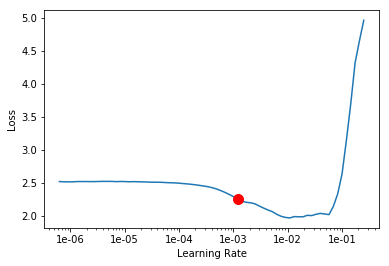

In [17]:
learn.recorder.plot(suggestion=True)

In [18]:
RLR = ReduceLROnPlateauCallback(learn, monitor='f_beta',patience = 2)
SAVEML = SaveModelCallback(learn, every='improvement', monitor='f_beta', name='best')

In [19]:
learn.fit_one_cycle(5, 1.20E-03, callbacks = [RLR, SAVEML])

epoch,train_loss,valid_loss,f_beta,time
0,0.641714,0.384689,0.585730,1:30:28
1,0.571693,0.390085,0.557317,1:30:30
2,0.513139,0.233777,0.727378,1:30:27
3,0.459339,0.232700,0.712384,1:30:52
4,0.418447,0.194167,0.787952,1:30:32


Better model found at epoch 0 with f_beta value: 0.5857304334640503.
Better model found at epoch 2 with f_beta value: 0.7273777723312378.
Better model found at epoch 4 with f_beta value: 0.7879524230957031.


In [20]:
#learn.save('efficient-1')

In [21]:
learn.load('best')

/home/bf/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (157040 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: CategoryList
19,19,0,0,0
Path: .;

Valid: LabelList (39259 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: CategoryList
8,18,0,0,0
Path: .;

Test: LabelList (153730 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: EmptyLabelList
,,,,
Path: ., model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False)
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.0100000

In [22]:
learn.unfreeze()

In [23]:
learn.lr_find(wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06


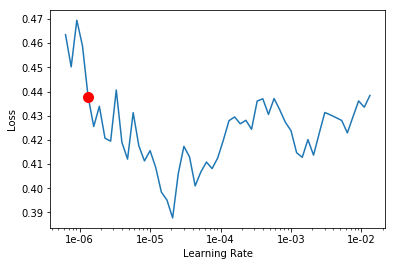

In [24]:
learn.recorder.plot(suggestion=True)

In [25]:
RLR = ReduceLROnPlateauCallback(learn, monitor='f_beta',patience = 2)
SAVEML = SaveModelCallback(learn, every='improvement', monitor='f_beta', name='best2')

In [26]:
learn.fit_one_cycle(5, 1e-5, callbacks = [RLR, SAVEML])

epoch,train_loss,valid_loss,f_beta,time
0,0.435474,0.196858,0.780374,1:30:51
1,0.402359,0.196528,0.780080,1:31:34
2,0.399825,0.192590,0.785698,1:31:02
3,0.388786,0.191318,0.784255,1:30:58
4,0.420115,0.188533,0.790553,1:30:57


Better model found at epoch 0 with f_beta value: 0.7803736925125122.
Better model found at epoch 2 with f_beta value: 0.7856978178024292.
Better model found at epoch 4 with f_beta value: 0.7905533313751221.


In [27]:
#learn.save('efficient-2')

In [13]:
learn.load('best2')

/home/bf/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (157040 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: CategoryList
19,19,0,0,0
Path: .;

Valid: LabelList (39259 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: CategoryList
8,18,0,0,0
Path: .;

Test: LabelList (153730 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: EmptyLabelList
,,,,
Path: ., model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False)
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.0100000

# LabelSmoothing

In [17]:
learn = Learner(data,getModel(False), true_wd=1e-2, metrics=[FBeta(average='macro')],loss_func=LabelSmoothingCrossEntropy()).to_fp16().mixup()


Loaded pretrained weights for efficientnet-b2


In [18]:
learn.load('best2')

Learner(data=ImageDataBunch;

Train: LabelList (157040 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: CategoryList
19,19,0,0,0
Path: .;

Valid: LabelList (39259 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: CategoryList
8,18,0,0,0
Path: .;

Test: LabelList (153730 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: EmptyLabelList
,,,,
Path: ., model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False)
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.0100000

In [19]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


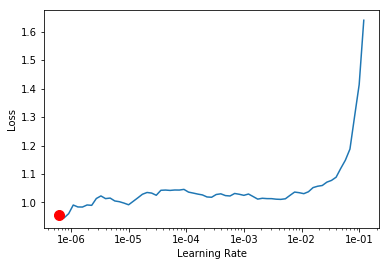

In [21]:
learn.recorder.plot(suggestion=True)

In [22]:
RLR = ReduceLROnPlateauCallback(learn, monitor='f_beta',patience = 2)
SAVEML = SaveModelCallback(learn, every='improvement', monitor='f_beta', name='best3')

In [23]:
learn.fit_one_cycle(5, 1e-5, callbacks = [RLR, SAVEML])

epoch,train_loss,valid_loss,f_beta,time
0,0.971700,0.753822,0.812152,1:29:58
1,0.926598,0.725500,0.825329,1:30:47
2,0.941728,0.720084,0.832993,1:29:31
3,0.924849,0.718025,0.835513,1:29:31
4,0.910940,0.718495,0.826221,1:29:31


Better model found at epoch 0 with f_beta value: 0.8121520280838013.
Better model found at epoch 1 with f_beta value: 0.8253293037414551.
Better model found at epoch 2 with f_beta value: 0.83299320936203.
Better model found at epoch 3 with f_beta value: 0.835512638092041.


In [24]:
learn.save('efficient-3')

In [25]:
learn.load('best3')

Learner(data=ImageDataBunch;

Train: LabelList (157040 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: CategoryList
19,19,0,0,0
Path: .;

Valid: LabelList (39259 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: CategoryList
8,18,0,0,0
Path: .;

Test: LabelList (153730 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: EmptyLabelList
,,,,
Path: ., model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False)
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.0100000

# Validation

In [26]:
pred, y = learn.get_preds()

In [27]:
from sklearn.metrics import f1_score
f1 = f1_score(y, np.argmax(pred.numpy(), 1), average='macro')  
f1

0.8366013751285547

# Inference

In [28]:
learn = learn.to_fp32()

In [29]:
#pred_t, _ = learn.get_preds(ds_type=DatasetType.Test)

In [30]:
pred_t, _ = learn.TTA(ds_type=DatasetType.Test)

In [31]:
import os
test_ids = [os.path.basename(f)[:-4] for f in learn.data.test_ds.items]
subm = pd.read_csv('sample_submission.csv')
orig_ids = list(subm['Id'])

In [32]:
pred_t2 = np.argmax(pred_t.numpy(), 1)

In [33]:
def create_submission(orig_ids, test_ids, preds):
    preds_dict = dict((k, v) for k, v in zip(test_ids, preds))
    pred_cor = [preds_dict[id] for id in orig_ids]
    df = pd.DataFrame({'id':orig_ids,'Predicted':pred_cor})
    df.to_csv(f'submission_{f1}.csv', header=True, index=False)
    return df

In [34]:
sub = create_submission(orig_ids, test_ids, pred_t2)

In [35]:
sub.tail()

,id,Predicted
153725,e6d895d3-2c07-11e9-bcad-06f10d5896c4,0
153726,2ce733a9-2c0b-11e9-bcad-06f10d5896c4,0
153727,69f21cf8-2c10-11e9-bcad-06f10d5896c4,0
153728,6cab4425-2c01-11e9-bcad-06f10d5896c4,0
153729,024c5972-2c1c-11e9-bcad-06f10d5896c4,0


In [43]:
! kaggle competitions submit -c iwildcam-2019-fgvc6 -f submission_0.8366013751285547.csv -m efficient_net_260

100%|███████████████████████████████████████| 5.73M/5.73M [00:10<00:00, 575kB/s]
Successfully submitted to iWildCam 2019 - FGVC6